## Importations

In [1]:
import mne 
import os
import pickle
import argparse
import scipy.stats
import matplotlib
import sklearn

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
from src.utils import get_bids_file, compute_ch_adjacency
from src.params import PREPROC_PATH, FREQS_LIST, FREQS_NAMES, EVENTS_ID, RESULT_PATH, SUBJ_CLEAN, FIG_PATH, ACTIVE_RUN, PASSIVE_RUN
from mne.time_frequency import (tfr_morlet, AverageTFR)
from mne.stats import spatio_temporal_cluster_test, spatio_temporal_cluster_1samp_test
from mne.stats import permutation_cluster_1samp_test,  permutation_cluster_test
from mne.stats import (
    spatio_temporal_cluster_test,
    f_threshold_mway_rm,
    f_mway_rm,
    summarize_clusters_stc,
)

In [16]:
# Conditions and task to compute
task = 'LaughterPassive'
stage = 'psd_epo'
cond1 = 'LaughReal'
cond2 = 'LaughPosed'
freq_name = FREQS_NAMES
condition = [cond1, cond2] # assert 2 conditions

# TODO : Take all event_id depending on task
for ev in EVENTS_ID :
    if task == 'LaughterActive' :
        event_id = {'Laugh/Real' : 11, 'Laugh/Posed' : 12, 'Press/Good' : 99, 'Press/Miss' : 66}
    elif task == 'LaughterPassive' : 
        event_id = {'Laugh/Real' : 11, 'Laugh/Posed' : 12, 'Env/Real' : 21, 'Scra/Real' : 31, 
                    'Env/Posed' : 22, 'Scra/Posed' : 32,}

## T-test clustering : Hilbert tranform
# ----------------------------------------INDUCED---------------------------------------------------

### 1. Prepare data

In [40]:
freq_name = FREQS_NAMES
condition = [cond1, cond2] # assert 2 conditions
list_good_cluster_inds = []

for FREQ, fname in enumerate(freq_name) : 

    for i, cond in enumerate(condition) :
        print('condition -->', cond)
        list_epochs_ave = []
        list_all_data = []
        
        for subj in SUBJ_CLEAN :
            print("processing subject -->", subj)
            list_epochs = []
            epochs_time = []

            for run in PASSIVE_RUN :
                print("processing run -->", run)
                
                # Get hilbert filtered data
                _, psd_path = get_bids_file(RESULT_PATH, 
                                            stage=stage, 
                                            subj=subj, 
                                            task=task, 
                                            run=run, 
                                            measure=fname)
                epochs = mne.read_epochs(psd_path, verbose=None)
                
                # Appliquer la correction baseline
                epochs = epochs.apply_baseline(baseline=(None, 0))
                list_epochs.append(epochs[cond])
                
            # Need to equalize event count
            mne.epochs.equalize_epoch_counts(list_epochs)

            for epo in list_epochs : # Use epochs with equal n_events

                # Moyenner chaque epoch dans le temps pour chaque condition
                epochs_ave_time = np.mean(epo.get_data(), axis = 2) # Shape (n_events, n_channels)
                epochs_time.append(epochs_ave_time) # len = n_runs

            epochs_ave_runs = np.mean(np.array(epochs_time), axis = 0) # Average across runs
            epochs_ave_event = np.mean(epochs_ave_runs, axis = 0) # Average across epochs
            list_epochs_ave.append(epochs_ave_event) # Shape (n_chan)

        # Concat subjects
        data_subj = np.array(list_epochs_ave)  # Shape (n_subj, n_chan)
        list_all_data.append(data_subj) # Append per freqs

        # Concat freqs fon each cond
        if i == 0 : 
            all_data_cond1 = np.array(list_all_data)
            all_data_cond1 = np.transpose(all_data_cond1, [1, 0, 2])
            #all_data_cond1 = data_subj
        elif i == 1 : 
            all_data_cond2 = np.array(list_all_data)
            all_data_cond2 = np.transpose(all_data_cond2, [1, 0, 2])
            #all_data_cond2 = data_subj
        
    print('all data condition 1 :', all_data_cond1.shape)  # Shape (n_subj, n_freq, n_chan)
    print('all data condition 2 :', all_data_cond2.shape)  # Shape (n_subj, n_freq, n_chan)

    data_contrast = np.subtract(all_data_cond1, all_data_cond2)

    print(data_contrast.shape)
    data_contrast = np.subtract(all_data_cond1, all_data_cond2)

    # Application de cluster permutation
    print('Computing adjacency.')
    adjacency, ch_names = compute_ch_adjacency(epochs.info, ch_type='mag')
    print(adjacency.shape)

    pval = 0.01  # arbitrary
    dfn = len([all_data_cond1, all_data_cond2]) - 1  # degrees of freedom numerator
    dfd = len(all_data_cond1) - len([all_data_cond1, all_data_cond2])  # degrees of freedom denominator
    thresh = scipy.stats.f.ppf(1 - pval, dfn=dfn, dfd=dfd)  # F distribution

    cluster_stats = \
        permutation_cluster_1samp_test(data_contrast, 
                                 adjacency = adjacency, 
                                 out_type='indices',
                                 n_permutations=1024, 
                                 threshold=None, 
                                 tail=0,
                                 step_down_p=0.05)

    list_good_cluster_inds.append(cluster_stats)

condition --> EnvReal
processing subject --> 01
processing run --> 07
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterActive_run-07_meas-delta_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)


KeyError: 'Event name "EnvReal" could not be found. The following events are present in the data: LaughReal, LaughPosed, Good, Miss'

In [3]:
# Save cluster stats to use it later
# TODO : save all subject evoked_cond1 et cond2 
conditions = cond1 + "-" + cond2

_, save_contrasts = get_bids_file(RESULT_PATH, stage = "psd-contrast", task=task, condition = conditions)

_, save_cluster_stats = get_bids_file(RESULT_PATH, stage = "psd-clusters", task=task, measure="Ttest-clusters", condition = conditions)

with open(save_contrasts, 'wb') as f:
     pickle.dump(data_contrast, f)  

with open(save_cluster_stats, 'wb') as f:
    pickle.dump(cluster_stats, f)  

NameError: name 'data_contrast' is not defined

### Test-t without permutation

In [11]:
# Save cluster stats to use it later
# TODO : save all subject evoked_cond1 et cond2 
conditions = cond1 + "-" + cond2

_, save_contrasts = get_bids_file(RESULT_PATH, stage = "psd-contrast", task=task, condition = conditions)

_, save_cluster_stats = get_bids_file(RESULT_PATH, stage = "psd-clusters", task=task, measure="Ttest-clusters", condition = conditions)

with open(save_contrasts, 'rb') as f:
     data_contrast = pickle.load(f)  

with open(save_cluster_stats, 'rb') as f:
    cluster_stats = pickle.load(f)  

In [8]:
# Test-t sans permutations, ni corrections pour la valeur de p

tval, pval = scipy.stats.ttest_rel(all_data_cond1, all_data_cond2)

good_pvalues_inds = np.where(pval < 0.01)[1]
print(good_pvalues_inds)

tvalues = np.squeeze(tval)
print(tvalues.shape)

NameError: name 'all_data_cond1' is not defined

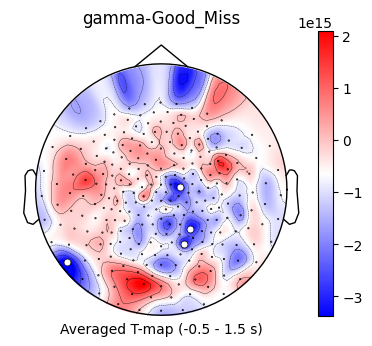

In [27]:
chan = np.arange(0, 270, 1)
mask = []

# initialize figure
fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

for i, ch in enumerate(chan) :
    if i in good_pvalues_inds : 
        mask.append((True, 0))
    else :
        mask.append((False, 0))
        
mask = np.array(mask)

# plot average test statistic and mark significant sensors
evoked = mne.EvokedArray(tvalues[:, np.newaxis], epochs.info, tmin=0)
evoked.plot_topomap(times=0, axes=ax_topo, cmap='bwr',
                    vlim=(np.min, np.max), show=False,
                    colorbar=False, mask=mask,
                    mask_params=dict(markersize=10), extrapolate='head',
                   sphere=(0, 0.015, 0, 0.19))

image = ax_topo.images[0]

# remove the title that would otherwise say "0.000 s"
ax_topo.set_title(fname + '-' + cond1 + '_' + cond2)

# create additional axes (for ERF and colorbar)
divider = make_axes_locatable(ax_topo)

# add axes for colorbar
ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(image, cax=ax_colorbar)
ax_topo.set_xlabel(
    "Averaged T-map (-0.5 - 1.5 s)"
)

plt.show()

### 2. Cluster permutation

In [12]:
data_contrast = np.subtract(all_data_cond1, all_data_cond2)

# Application de cluster permutation

# TODO : check adjacency
print('Computing adjacency.')
adjacency, ch_names = compute_ch_adjacency(epochs.info, ch_type='mag')
print(adjacency.shape)

pval = 0.01  # arbitrary
dfn = len([all_data_cond1, all_data_cond2]) - 1  # degrees of freedom numerator
dfd = len(all_data_cond1) - len([all_data_cond1, all_data_cond2])  # degrees of freedom denominator
thresh = scipy.stats.f.ppf(1 - pval, dfn=dfn, dfd=dfd)  # F distribution

cluster_stats = \
    permutation_cluster_1samp_test(data_contrast, 
                             adjacency = adjacency, 
                             out_type='indices',
                             n_permutations=1024, 
                             threshold=None, 
                             tail=0,
                             step_down_p=0.05)

list_good_cluster_inds.append(cluster_stats)

Computing adjacency.


NameError: name 'epochs' is not defined

### 3. Plot 

In [17]:
# Get hilbert filtered epochs for electrods
_, psd_path = get_bids_file(RESULT_PATH, 
                            stage=stage, 
                            subj='01', 
                            task=task, 
                            run='07', 
                            measure='alpha')
epochs = mne.read_epochs(psd_path, verbose=None)

all_freqs_clusters = {}

for FREQ, fname in enumerate(freq_name) : 

    conditions = cond1 + "-" + cond2 + '-' + fname

    _, save_contrasts = get_bids_file(RESULT_PATH, stage = "psd-contrast", task=task, condition = conditions)

    _, save_cluster_stats = get_bids_file(RESULT_PATH, stage = "psd-clusters", task=task, measure="Ttest-clusters", condition = conditions)

    with open(save_contrasts, 'rb') as f:
         data_contrast = pickle.load(f)  

    with open(save_cluster_stats, 'rb') as f:
        cluster_stats = pickle.load(f)  
        
    all_freqs_clusters[fname] = cluster_stats
    
    F_obs, clusters, p_values, _ = cluster_stats

    p_accept = 0.01
    good_cluster_inds = np.where(p_values < p_accept)[0]

    print("Good clusters: %s" % good_cluster_inds)

Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterActive_run-07_meas-alpha_psd_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated


FileNotFoundError: [Errno 2] No such file or directory: '/home/claraelk/scratch/laughter_data/results/meg/reports/sub-all/sub-all_task-LaughterPassive_run-all_cond-LaughReal-LaughPosed-delta_psd-contrast.fif'

In [18]:
F_obs, clusters, p_values, _ = cluster_stats

p_accept = 0.01
good_cluster_inds = np.where(p_values < p_accept)[0]

print("Good clusters: %s" % good_cluster_inds)

for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpack cluster information, get unique indices
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)
    
    t_map = F_obs[time_inds, ...].mean(axis=0)

    # create spatial mask
    mask = np.zeros((t_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

    # plot average test statistic and mark significant sensors
    f_evoked = mne.EvokedArray(t_map[:, np.newaxis], epochs.info, tmin=0)
    f_evoked.plot_topomap(times=0, mask=mask, axes=ax_topo, cmap='bwr',
                          vlim=(np.min, np.max), show=False,
                          colorbar=False, mask_params=dict(markersize=10))
    
    image = ax_topo.images[0]

    # remove the title that would otherwise say "0.000 s"
    ax_topo.set_title(fname + '-' + cond1 + '_' + cond2 + 'permutations')

    # create additional axes (for ERF and colorbar)
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        "Averaged T-map (-0.5 - 1.5 s)"
    )
    
    plt.show()

Good clusters: []


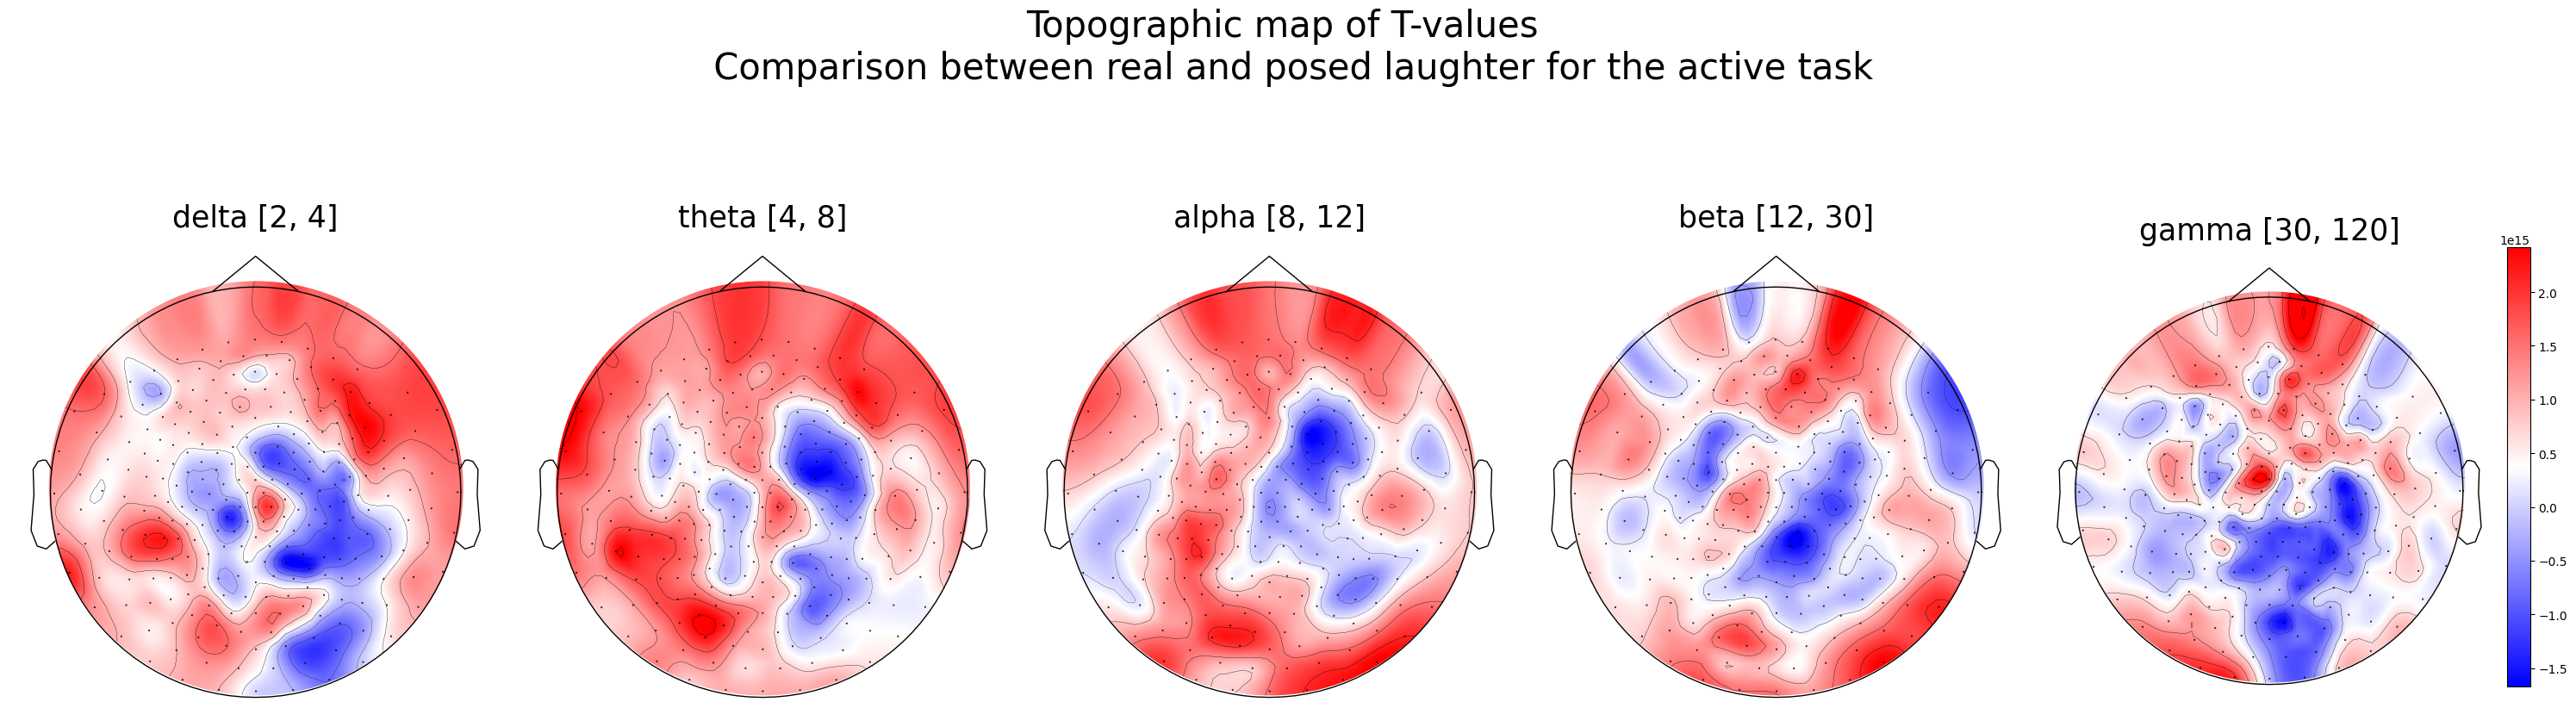

In [15]:
condition_name = cond1 + '_' + cond2

# Initialize Figure
fig, axes = plt.subplots(1, 5, figsize=(30, 10))

topomap_kw = dict(ch_type='mag', tmin=0.5, tmax=1.5, baseline=(-0.5, 0),
                mode='logratio', show=False)

fig_path = FIG_PATH + 'clusters-psd/sub-all_run-all_task-{}_cond-LaughReal_LaughPosed'.format(task)
 

for i, ax in enumerate(axes):
    
    freq = freq_name[i]
        
    cluster_stats = all_freqs_clusters[freq]
    F_obs, clusters, p_values, _ = cluster_stats

    p_accept = 0.01
    good_cluster_inds = np.where(p_values < p_accept)[0]

    if len(good_cluster_inds) > 0:

        for i_clu, clu_idx in enumerate(good_cluster_inds):
            # unpack cluster information, get unique indices
            time_inds, space_inds = np.squeeze(clusters[clu_idx])
            ch_inds = np.unique(space_inds)
            time_inds = np.unique(time_inds)

            t_map = F_obs[time_inds, ...].mean(axis=0)

            # create spatial mask
            mask = np.zeros((t_map.shape[0], 1), dtype=bool)
            mask[ch_inds, :] = True

            # plot average test statistic and mark significant sensors
            f_evoked = mne.EvokedArray(t_map[:, np.newaxis], epochs.info, tmin=0)
            f_evoked.plot_topomap(times=0, mask=mask, axes=ax, cmap='bwr',
                                  show=False,
                                  cnorm = matplotlib.colors.CenteredNorm(vcenter=0),
                                  colorbar=False, mask_params=dict(markersize=10), 
                                  extrapolate='head',
                                  sphere=(0, 0.017, 0, 0.184))

            image = ax.images[0]

            # remove the title that would otherwise say "0.000 s"
            title = FREQS_NAMES[i] + ' ' + str(FREQS_LIST[i])
            ax.set_title(title, size = 25)

    else : 
        t_map = np.squeeze(F_obs)
        # time_inds, space_inds = np.squeeze(clusters[clu_idx])
        # ch_inds = np.unique(space_inds)
        # time_inds = np.unique(time_inds)
        # t_map = F_obs[time_inds, ...].mean(axis=0)


        # plot average test statistic without mark significant sensors
        f_evoked = mne.EvokedArray(t_map[:, np.newaxis], epochs.info, tmin=0)
        f_evoked.plot_topomap(times=0, axes=ax, cmap='bwr',
                              vlim=(np.min, np.max), show=False,
                              colorbar=False, extrapolate='head',
                                  sphere=(0, 0.017, 0, 0.184))

        image = ax.images[0]

        # remove the title that would otherwise say "0.000 s"
        title = FREQS_NAMES[i] + ' ' + str(FREQS_LIST[i])
        ax.set_title(title, size = 25)


# create additional axes (for ERF and colorbar)
divider = make_axes_locatable(ax)

# add axes for colorbar
ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(image, cax=ax_colorbar)

figure_title = 'Topographic map of T-values \n Comparison between real and posed laughter for the active task'
plt.suptitle(figure_title, size = 30)
fig.tight_layout()
fig.savefig(fig_path)

----------------------------------------------------------------------------------------------------------------

# TEST TIME FREQUENCY